## Preprocessing

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces import fsl 
from nipype.interfaces import spm
from nipype.interfaces.spm import (Realign, SliceTiming, Coregister,  NewSegment,  Normalize12, Smooth)
from nipype.interfaces import matlab as mlab
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.interfaces.utility as util 
from nipype.algorithms import rapidart as ra
from nipype.interfaces.utility import IdentityInterface
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype import DataGrabber, Workflow, Node

In [2]:
os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/'))

'/home/matay/Documents/MATLAB/spm12'

In [3]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [4]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')))

In [5]:
# spm.SPMCommand().version

In [6]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [7]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [9]:
experiment_dir = os.path.join(base_dir, 'output')
data_dir = os.path.abspath(os.path.join(base_dir, 'face_rep'))
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['M03953']
# below info referred by datagrabber needs to be referred within infosource, selectfiles 
#info = dict(
#    func=[['RawEPI', 'subject_id', 5, ["_%04d" % i for i in range(6, 357)]]],
#    struct=[['Structural', 'subject_id', 7, '']])

# TR of functional images
#TR = 2.
# Smoothing width used during preprocessing
fwhm = [8]

In [10]:
num = list(range(6, 357))

In [11]:
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

In [15]:
datasource = Node(
    interface=DataGrabber(
        infields=['subject_id'], outfields=['func', 'struct']),
    name='datasource')
datasource.inputs.base_directory = data_dir
datasource.inputs.template = '%s/s%s_%04d%s.img'
datasource.inputs.template_args = info
datasource.inputs.sort_filelist = True

In [13]:
merge = Node(interface=fsl.Merge(), name="merge")
merge.inputs.dimension = "t" 
merge.inputs.output_type = 'NIFTI'

In [14]:
realigner = Node(interface=Realign(), name='realign')
# realigner.inputs.in_files = func_file
realigner.inputs.register_to_mean = True
realigner.inputs.fwhm = 5
realigner.inputs.interp = 2
realigner.inputs.quality = 0.9
realigner.inputs.separation = 4
realigner.inputs.wrap = [0, 0, 0]
realigner.inputs.write_which = [2, 1]
realigner.inputs.write_interp = 4 
realigner.inputs.write_wrap = [0, 0, 0]
realigner.inputs.write_mask = True
realigner.inputs.jobtype = 'estwrite'
realigner.inputs.out_prefix = 'r'

In [15]:
slicetiming = Node(interface=SliceTiming(), name = 'slicetiming')
# st.inputs.in_files = anat_file
slicetiming.inputs.num_slices = 24
slicetiming.inputs.time_repetition = 2.
slicetiming.inputs.time_acquisition = 1.92
slicetiming.inputs.slice_order = list(range(24,0,-1))
slicetiming.inputs.ref_slice = 12
slicetiming.inputs.out_prefix = 'a'

In [16]:
coregister = Node(Coregister(), name="coregister")
coregister.inputs.jobtype = 'estimate'
coregister.inputs.cost_function = 'nmi'
coregister.inputs.fwhm = [7.0, 7.0]
coregister.inputs.separation = [4.0, 2.0]
coregister.inputs.tolerance = [0.02, 0.02, 0.02, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001]

In [17]:
tpm_path = os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/tpm/', 'TPM.nii'))

In [18]:
segment =  Node(NewSegment(), name="newsegment")
# seg.inputs.channel_files = '/data/preproc/coregister/sub-01_T1w.nii'
#seg.inputs.channel_files = '/data/MoAEpilot_raw/sub-01/anat/sub-01_T1w.nii'
segment.inputs.affine_regularization = 'mni'
segment.inputs.channel_info = (0.001, 60, (False, True)) #save bias corrected map
tissue1 = ((tpm_path, 1), 1, (True, False), (False, False))
tissue2 = ((tpm_path, 2), 1, (True, False), (False, False))
tissue3 = ((tpm_path, 3), 2, (True, False), (False, False))
tissue4 = ((tpm_path, 4), 3, (True, False), (False, False))
tissue5 = ((tpm_path, 5), 4, (True, False), (False, False))
tissue6 = ((tpm_path, 6), 2, (False, False), (False, False))
segment.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
segment.inputs.warping_regularization = [0, 0.001, 0.5, 0.05, 0.2]
segment.inputs.sampling_distance = 3
segment.inputs.write_deformation_fields = [False, True] 

stty: 'standard input': Inappropriate ioctl for device


In [19]:
normalize = Node(Normalize12(), name="normalize") 
normalize.inputs.jobtype = 'write'
normalize.inputs.write_bounding_box =  [[-78, -112, -70], [78, 76, 85]]
normalize.inputs.write_voxel_sizes = [3, 3, 3]
normalize.inputs.write_interp = 4
normalize.inputs.out_prefix = 'w'

In [24]:
smooth = Node(Smooth(), name="smooth")
smooth.inputs.fwhm = [8, 8, 8]
smooth.inputs.data_type = 0
smooth.inputs.implicit_masking = False
smooth.inputs.out_prefix = 's'

In [25]:
sink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [21]:
def get_vox_dims(volume):
    import nibabel as nb
    if isinstance(volume, list):
        volume = volume[0]
    nii = nb.load(volume)
    hdr = nii.header
    voxdims = hdr.get_zooms()
    return [float(voxdims[0]), float(voxdims[1]), float(voxdims[2])]

In [22]:
preproc = Workflow(name='event_preproc')
preproc.base_dir = os.path.join(experiment_dir, working_dir)

In [27]:
preproc.connect([(infosource, datasource, [('subject_id', 'subject_id')]),
                 (datasource, merge, [('func', 'in_files')]),
                 (merge, sink, [('merged_file', 'preproc.@merged_file')]),
                 (merge, realigner, [('merged_file', 'in_files')]),
                 (realigner, slicetiming, [('realigned_files', 'in_files')]),
                 (realigner, coregister, [('mean_image', 'source'), 
                                          ('realigned_files', 'apply_to_files')]),
                 (realigner, sink, [('realignment_parameters', 'preproc.@realignement_parameters')]),
                 (datasource, coregister, [('struct', 'target')]), 
                 (coregister, sink, [('coregistered_source', 'preproc.@coregisered_source')]),
                 (coregister, segment, [('coregistered_source', 'channel_files')]),
                 (segment, sink, [('bias_corrected_images', 'preproc.@bias_corrected_images'), 
                                 ('transformation_mat', 'preproc.@transformation_mat'),
                                 ('native_class_images', 'preproc.@native_class_images')]),
                 (segment, normalize, [('forward_deformation_field', 'deformation_file')]),
                 (slicetiming, normalize, [('timecorrected_files', 'apply_to_files'),
                                          (('timecorrected_files', get_vox_dims),
                                     'write_voxel_sizes')]),
                 (normalize, smooth, [('normalized_files', 'in_files')]),
])

In [27]:
preproc.write_graph(graph2use='colored', format='png', dotfilename='colored_graph.dot', simple_form=True)

240516-18:21:27,325 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_preproc_sel/colored_graph.png (graph2use=colored, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_preproc_sel/colored_graph.png'

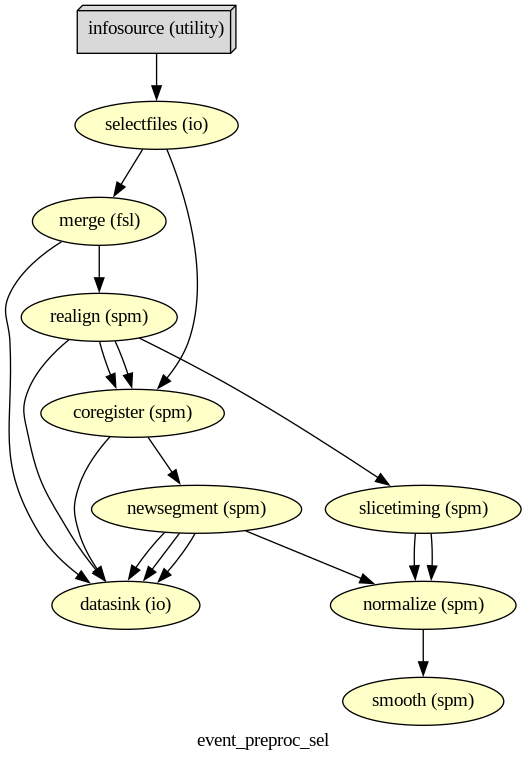

In [29]:
# Visualize the graph
from IPython.display import Image
Image(filename='/home/matay/spmbasics/data/output/workingdir/event_preproc_sel/colored_graph.png', width=750)

In [30]:
preproc.write_graph(graph2use='flat', format='png', simple_form=True, dotfilename='flat_graph.dot')

240516-18:21:55,242 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_preproc_sel/flat_graph.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_preproc_sel/flat_graph.png'

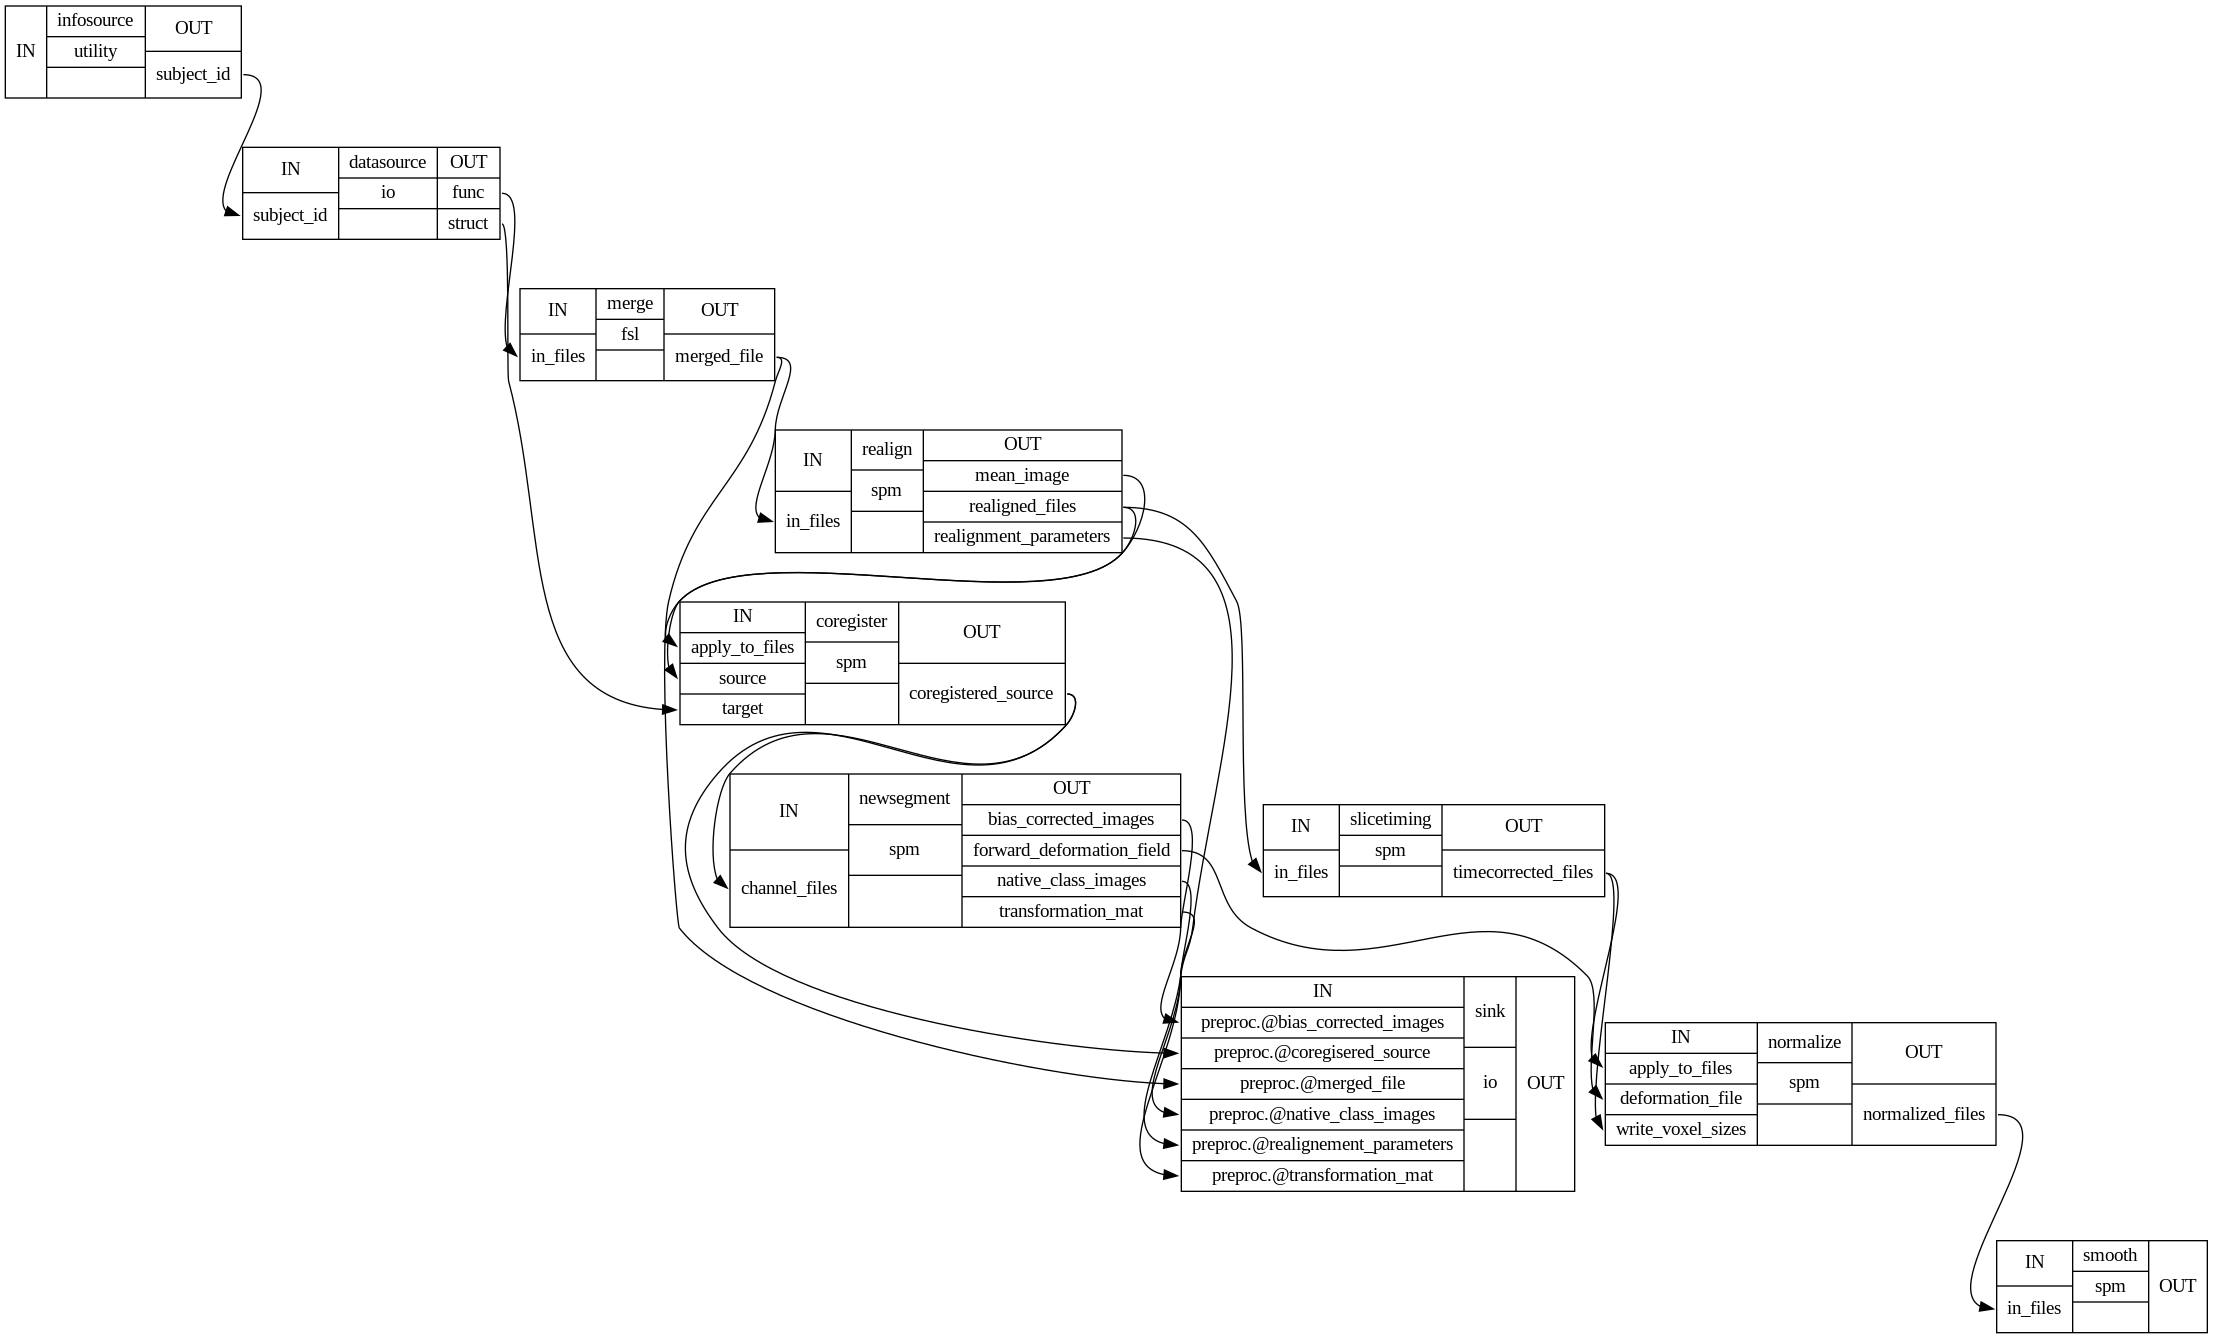

In [30]:
from IPython.display import Image
Image(filename='./spmbasics/data/output/workingdir/event_preproc/flat_graph_detailed.png' )

In [31]:
preproc.run()

240516-18:21:59,204 nipype.workflow INFO:
	 Workflow event_preproc_sel settings: ['check', 'execution', 'logging', 'monitoring']
240516-18:21:59,214 nipype.workflow INFO:
	 Running serially.
240516-18:21:59,214 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_sel.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_sel/_subject_id_M03953/selectfiles".
240516-18:21:59,215 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240516-18:21:59,217 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.000307s.
240516-18:21:59,217 nipype.workflow WARNING:
	 Storing result file without outputs
240516-18:21:59,218 nipype.workflow WARNING:
	 [Node] Error on "event_preproc_sel.selectfiles" (/home/matay/spmbasics/data/output/workingdir/event_preproc_sel/_subject_id_M03953/selectfiles)
240516-18:21:59,219 nipype.workflow ERROR:
	 Node selectfiles.a0 failed to run on host ptb-03240070.irisa.fr.
240516-18:21:59,219 ni

NodeExecutionError: Exception raised while executing Node selectfiles.

Traceback:
	Traceback (most recent call last):
	  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 400, in run
	    outputs = self.aggregate_outputs(runtime)
	  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 429, in aggregate_outputs
	    predicted_outputs = self._list_outputs()  # Predictions from _list_outputs
	  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/interfaces/io.py", line 1469, in _list_outputs
	    raise IOError(msg)
	OSError: No files were found matching func template: /home/matay/spmbasics/data/face_rep/RawEPI/sM03953_0005_<undefined>.img
